# Social Network Analysis applied to Data Warehouses

## 3. Network Connectivity Analysis: Betweenness Centrality

Some measures depend not only on a node's direct connections but also on its structural position in the network. **Betweenness centrality**, which refers to the number of times a given node is found in the shortest paths among other nodes, is one of them. Nodes with large betweenness are the primary conductors of information, also called network influencers. In other words, if the betweenness is high, the node is potentially a crucial go-between (thus the name) and has a brokerage capability ([Zinoviev, 2018][Zin18]). The shortest paths in a graph can eventually materialize as data pipelines in the Data Warehouse, and betweenness centrality brings insights about the assets that have a higher potential to cause such workloads to fail.

[Zin18]: https://pragprog.com/titles/dzcnapy/complex-network-analysis-in-python/

### 3.1. Import dependencies

In [1]:
import itertools
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
from networkx.classes.graph import Graph
import numpy as np
import pandas as pd
from pandas import Series

### 3.2. Utility functions

In [2]:
def load_graph_from_csv(file: str) -> Graph:
    return nx.read_edgelist(file, delimiter=",", create_using=nx.DiGraph)

In [3]:
def format_graph_info(graph_id: str, graph: Graph) -> str:
    return (
        f"{graph_id.upper()} GRAPH INFO:\n"
        f"  Number of nodes: {nx.number_of_nodes(graph)}\n"
        f"  Number of edges: {nx.number_of_edges(graph)}\n"
        f"  Density: {nx.density(graph)}\n"
        f"  Average clustering coefficient: {nx.average_clustering(graph)}\n"
        f"  Transitivity: {nx.transitivity(graph)}"
    )

In [4]:
def get_betweenness_centrality(graph: Graph) -> Dict[str, float]:
    return nx.betweenness_centrality(graph, normalized=False)

In [5]:
def get_betweenness_centrality_list(bet_cent: Dict[str, float]) -> List[float]:
    return [betweenness for _, betweenness in bet_cent.items()]

In [6]:
def get_betweenness_centrality_series(bet_cent: Dict[str, float]) -> Series:
    return pd.Series(get_betweenness_centrality_list(bet_cent))

In [7]:
def draw_betweenness_centrality_based_network(
    graph: Graph, bet_cent: Dict[str, float]
) -> None:
    sorted_bet_cent = sorted(get_betweenness_centrality_list(bet_cent))

    lowest_non_zero_bet_cent = next(
        betweenness for betweenness in sorted_bet_cent if betweenness > 0
    )
    highest_bet_cent = sorted_bet_cent[-1]
    scaling_factor = 3500 / highest_bet_cent

    normalized_node_params = [
        (betweenness or (lowest_non_zero_bet_cent / 10)) * scaling_factor
        for betweenness in sorted_bet_cent
    ]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph),
        with_labels=False,
        edge_color="dimgray",
        node_color=normalized_node_params,
        node_size=normalized_node_params,
    )
    plt.axis("off")

In [8]:
def plot_betweenness_centrality_descriptive_stats(
    bet_cent: Dict[str, float], color: str
) -> None:
    bet_cent_list = get_betweenness_centrality_list(bet_cent)

    plt.figure(figsize=(12, 3))
    plt.boxplot(bet_cent_list, vert=False, flierprops=dict(markerfacecolor=color))
    plt.xlabel("Betweenness Centrality")

In [9]:
def plot_betweenness_centrality_ranking(
    bet_cent: Dict[str, float], fmt: str, stop_at: float = 0
) -> None:
    sorted_bet_cent = sorted(get_betweenness_centrality_list(bet_cent), reverse=True)

    if stop_at:
        stop_at_index = sorted_bet_cent.index(stop_at)
        while sorted_bet_cent[stop_at_index] == sorted_bet_cent[stop_at_index + 1]:
            stop_at_index += 1

    adjusted_list = [None]
    adjusted_list.extend(
        sorted_bet_cent[: stop_at_index + 1] if stop_at else sorted_bet_cent
    )

    plt.figure(figsize=(12, 3))
    plt.plot(adjusted_list, fmt)
    plt.xlabel("Rank")
    plt.ylabel("Betweenness Centrality")

In [10]:
def group_nodes_by_betweenness_centrality(
    bet_cent: Dict[str, float], highest_first: bool = True
) -> Dict[float, List[str]]:
    bet_cent_list = get_betweenness_centrality_list(bet_cent)
    unique_bet_cent = sorted(np.unique(bet_cent_list), reverse=highest_first)
    sorted_bet_cent_dict = {}
    for value in unique_bet_cent:
        sorted_bet_cent_dict[value] = sorted(
            [node for node, bc in bet_cent.items() if bc == value]
        )
    return sorted_bet_cent_dict

In [11]:
def get_betweenness_centrality_critical_nodes_for_count(
    bet_cent: Dict[str, float], target_node_count
) -> Tuple[Dict[int, List[str]], float]:
    node_count = 0
    bc_groups = group_nodes_by_betweenness_centrality(bet_cent)

    group_count = 0
    while node_count < target_node_count:
        group_count += 1
        highest_bc = dict(itertools.islice(bc_groups.items(), group_count))
        node_count = sum([len(nodes) for _, nodes in highest_bc.items()])

    print(f"{group_count}-critical-groups node count: {node_count}\n")

    return highest_bc, node_count

### 3.3. Load the anonymized graphs from CSV and cache their Betweenness Centrality data

In [12]:
anon_data_folder = "../data/anonymized"

small_graph_1 = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-small_1.csv")
print(f'{format_graph_info("small(1)", small_graph_1)}\n')

small_graph_2 = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-small_2.csv")
print(f'{format_graph_info("small(2)", small_graph_2)}\n')

medium_graph = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-medium.csv")
print(f'{format_graph_info("medium", medium_graph)}\n')

large_graph = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-large.csv")
print(f'{format_graph_info("large", large_graph)}')

SMALL(1) GRAPH INFO:
  Number of nodes: 827
  Number of edges: 904
  Density: 0.0013233748400678083
  Average clustering coefficient: 0.008543182152613835
  Transitivity: 0.0034873583260680036

SMALL(2) GRAPH INFO:
  Number of nodes: 658
  Number of edges: 1400
  Density: 0.003238446840895107
  Average clustering coefficient: 0.12371040219915662
  Transitivity: 0.06696664902064585

MEDIUM GRAPH INFO:
  Number of nodes: 8298
  Number of edges: 9458
  Density: 0.00013737407751447794
  Average clustering coefficient: 0.005819181276085573
  Transitivity: 0.012780414150129421

LARGE GRAPH INFO:
  Number of nodes: 14511
  Number of edges: 24990
  Density: 0.00011868654882455435
  Average clustering coefficient: 0.04760245618981202
  Transitivity: 0.0035961744144591013


In [13]:
small_graph_1_bc = get_betweenness_centrality(small_graph_1)
small_graph_2_bc = get_betweenness_centrality(small_graph_2)
medium_graph_bc = get_betweenness_centrality(medium_graph)
large_graph_bc = get_betweenness_centrality(large_graph)

### 3.4. Draw the networks, plot Betweenness Centrality data, etc

#### 3.4.1. Small network 1

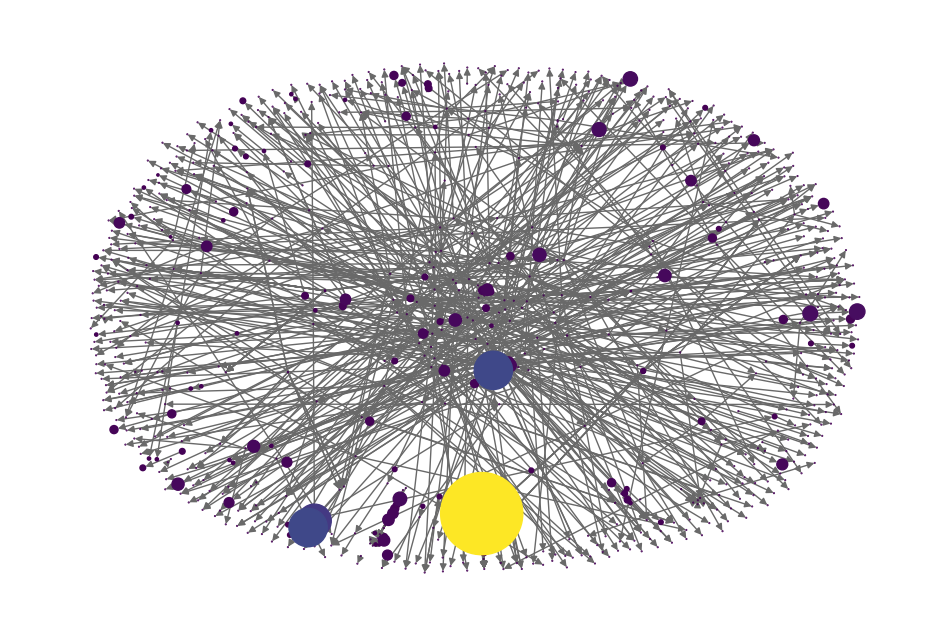

In [14]:
draw_betweenness_centrality_based_network(small_graph_1, small_graph_1_bc)

In [15]:
sg_1_bet_cent_series = get_betweenness_centrality_series(small_graph_1_bc)
print(sg_1_bet_cent_series.describe())

count    827.000000
mean       2.246675
std       23.274047
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      625.000000
dtype: float64


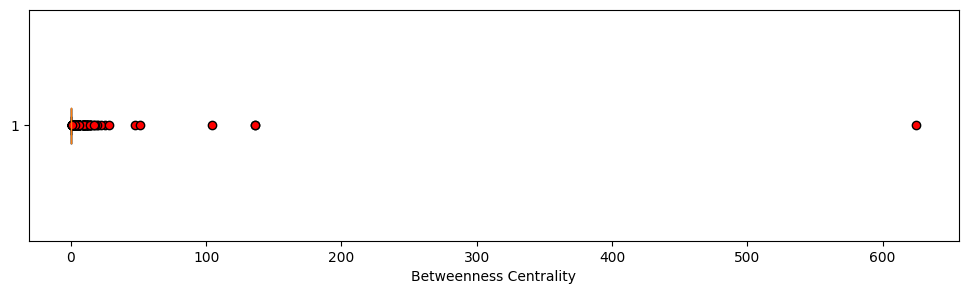

In [16]:
plot_betweenness_centrality_descriptive_stats(small_graph_1_bc, "red")

Like what was observed in the out-degree analysis, there are few nodes with high betweenness centrality in each of the four datasets, as summarized by the above descriptive statistics and box plot chart. Again, the research shows no clear threshold that can be used to determine the key assets from the betweenness centrality perspective.

However, ranking the assets according to their betweenness centralities makes it feasible to point out the outliers, which Data Governance folks should pay special attention to.

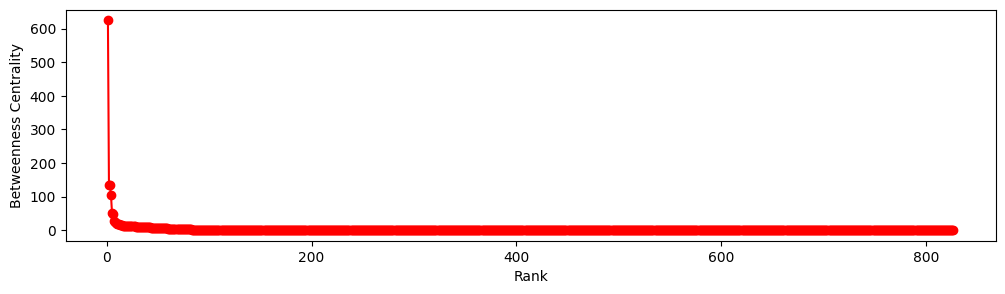

In [17]:
plot_betweenness_centrality_ranking(small_graph_1_bc, "ro-")

In [18]:
sg_1_critical_groups, _ = get_betweenness_centrality_critical_nodes_for_count(
    small_graph_1_bc, 10
)
print(f"\n{sg_1_critical_groups}")

9-critical-groups node count: 10


{625.0: ['10025'], 136.0: ['10114', '10131'], 104.0: ['10037'], 51.0: ['10130'], 47.166666666666664: ['10007'], 28.166666666666664: ['10582'], 25.166666666666668: ['10020'], 22.0: ['10202'], 20.0: ['10144']}


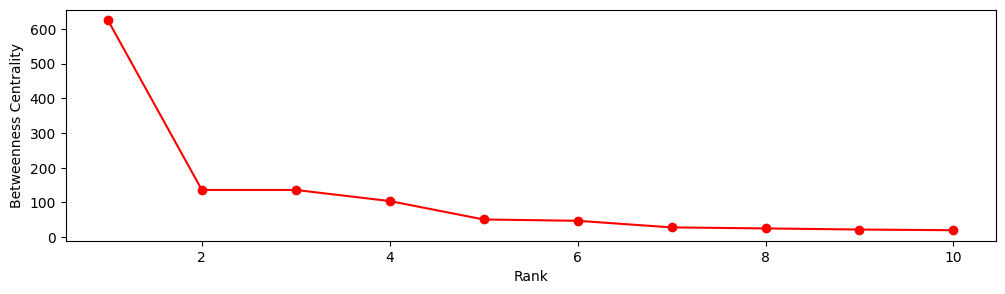

In [19]:
plot_betweenness_centrality_ranking(
    small_graph_1_bc,
    "ro-",
    stop_at=list(sg_1_critical_groups.keys())[-1],
)

#### 3.4.2. Small network 2

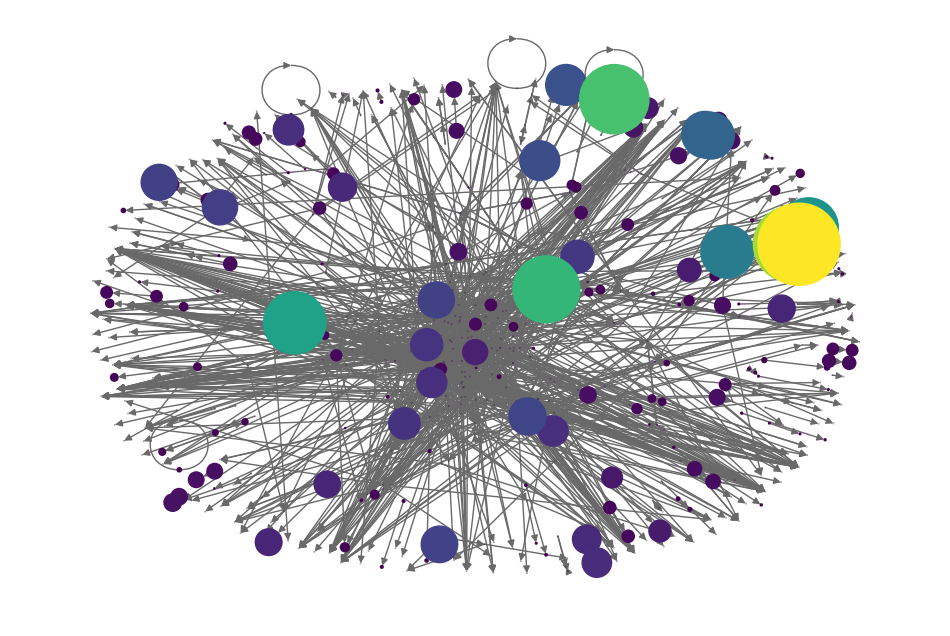

In [20]:
draw_betweenness_centrality_based_network(small_graph_2, small_graph_2_bc)

In [21]:
sg_2_bet_cent_series = get_betweenness_centrality_series(small_graph_2_bc)
print(sg_2_bet_cent_series.describe())

count     658.000000
mean       71.989362
std       361.302905
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      4587.158894
dtype: float64


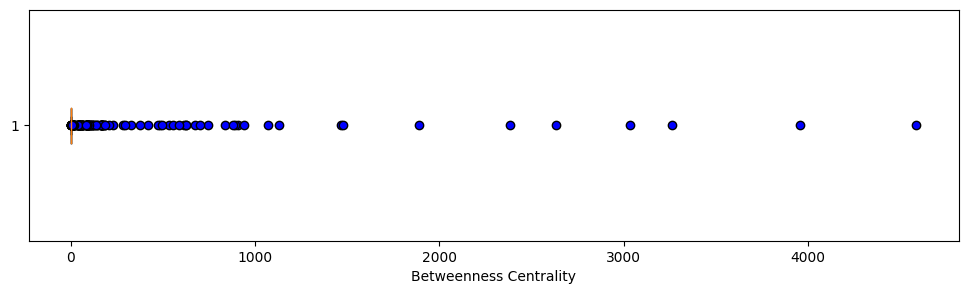

In [22]:
plot_betweenness_centrality_descriptive_stats(small_graph_2_bc, "blue")

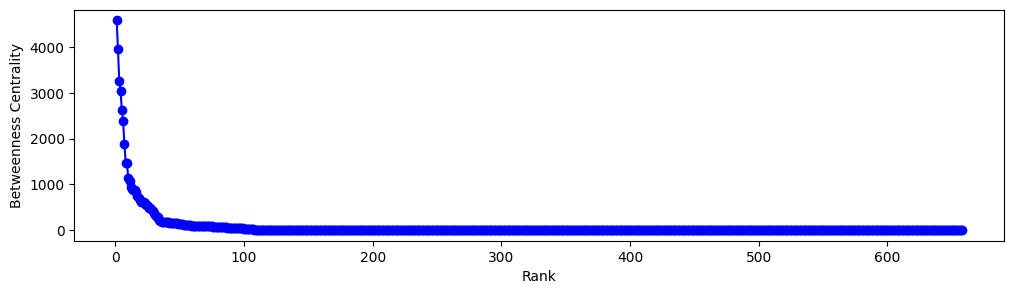

In [23]:
plot_betweenness_centrality_ranking(small_graph_2_bc, "bo-")

In [24]:
sg_2_critical_groups, _ = get_betweenness_centrality_critical_nodes_for_count(
    small_graph_2_bc, 10
)
print(f"\n{sg_2_critical_groups}")

10-critical-groups node count: 10


{4587.158893883894: ['20044'], 3956.9838550338545: ['20064'], 3259.522546897547: ['20012'], 3036.158441558441: ['20076'], 2634.326273726273: ['20110'], 2381.6121101121093: ['20263'], 1886.592446442446: ['20048'], 1477.8060550560542: ['20474'], 1467.8060550560544: ['20394'], 1130.9250915750915: ['20098']}


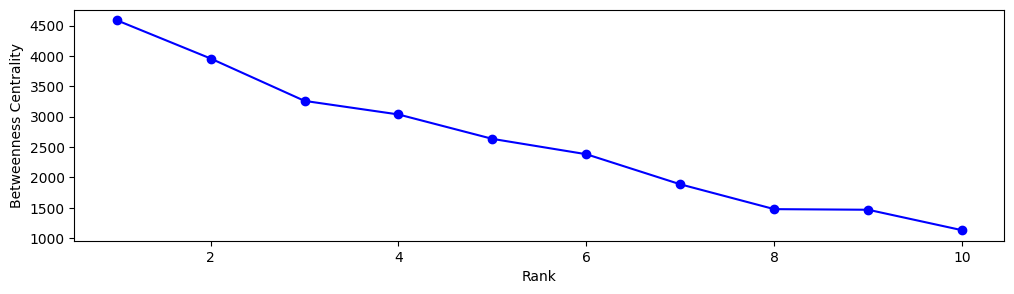

In [25]:
plot_betweenness_centrality_ranking(
    small_graph_2_bc,
    "bo-",
    stop_at=list(sg_2_critical_groups.keys())[-1],
)

#### 3.4.3. Medium network

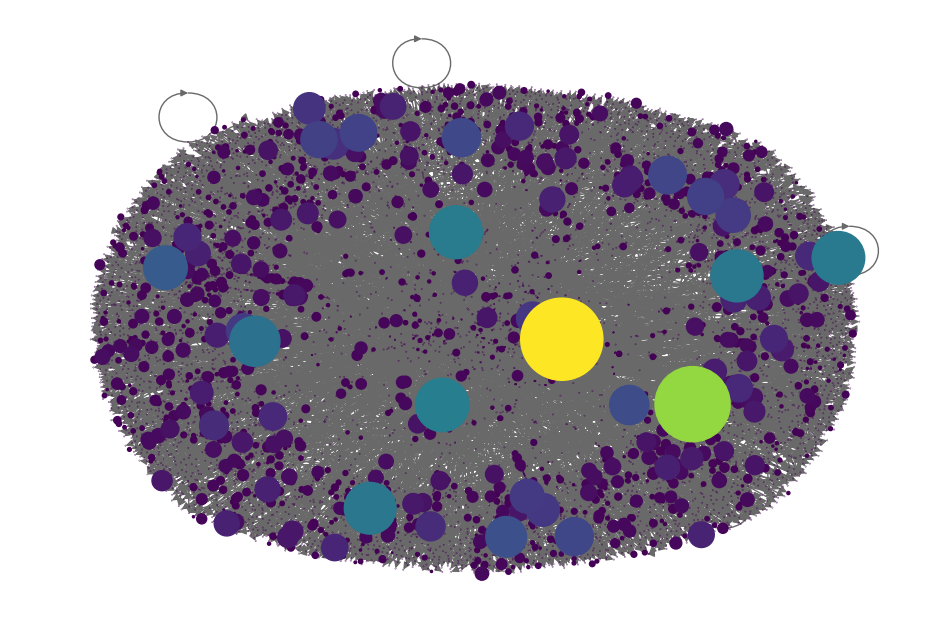

In [26]:
draw_betweenness_centrality_based_network(medium_graph, medium_graph_bc)

In [27]:
mg_bet_cent_series = get_betweenness_centrality_series(medium_graph_bc)
print(mg_bet_cent_series.describe())

count    8298.000000
mean        3.878163
std        30.019997
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1403.666667
dtype: float64


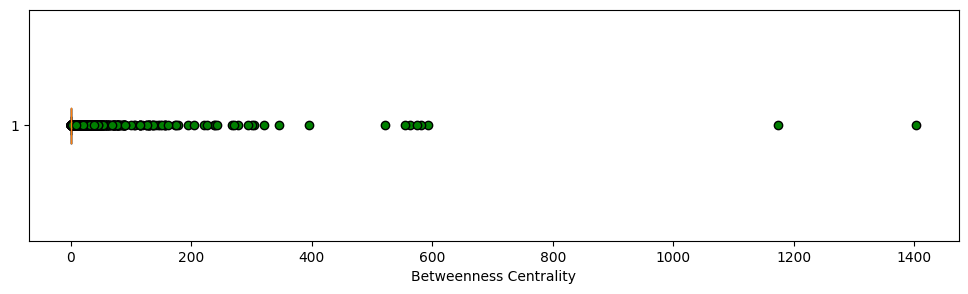

In [28]:
plot_betweenness_centrality_descriptive_stats(medium_graph_bc, "green")

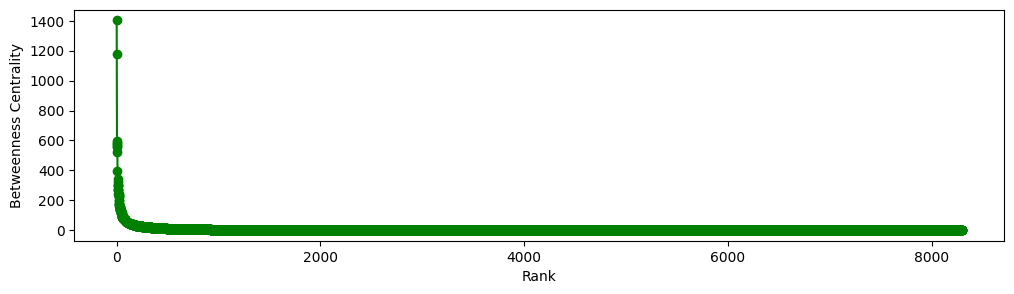

In [29]:
plot_betweenness_centrality_ranking(medium_graph_bc, "go-")

In [30]:
mg_critical_groups, _ = get_betweenness_centrality_critical_nodes_for_count(
    medium_graph_bc, 10
)
print(f"\n{mg_critical_groups}")

10-critical-groups node count: 10


{1403.6666666666665: ['300191'], 1174.6666666666667: ['300298'], 593.3333333333334: ['300123'], 581.3333333333334: ['300700'], 575.0: ['302201'], 563.6666666666666: ['301527'], 554.6666666666666: ['301970'], 521.5: ['300576'], 396.0: ['300787'], 345.33333333333337: ['300396']}


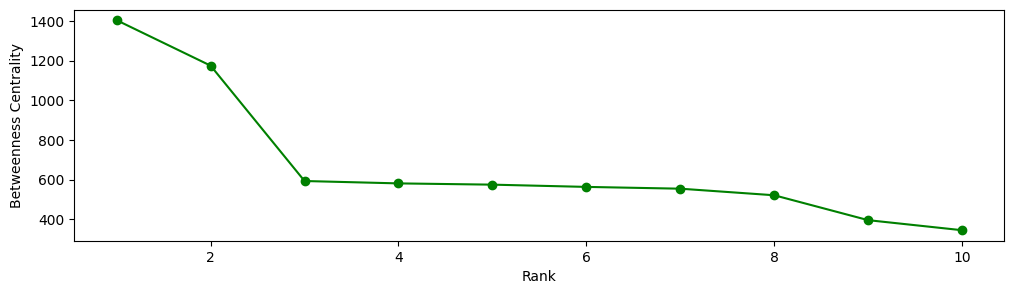

In [31]:
plot_betweenness_centrality_ranking(
    medium_graph_bc,
    "go-",
    stop_at=list(mg_critical_groups.keys())[-1],
)

#### 3.4.4. Large network

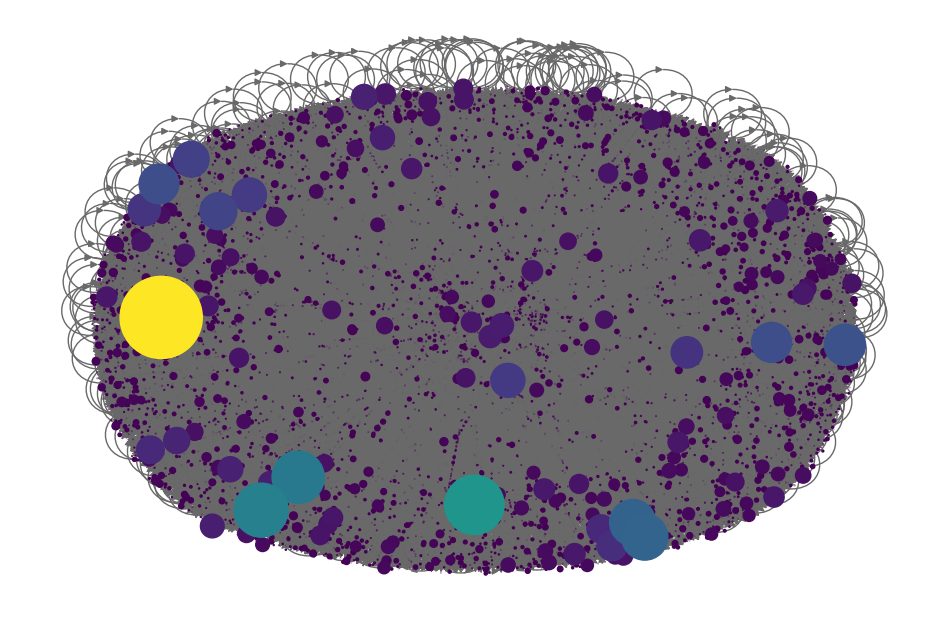

In [32]:
draw_betweenness_centrality_based_network(large_graph, large_graph_bc)

In [33]:
lg_bet_cent_series = get_betweenness_centrality_series(large_graph_bc)
print(lg_bet_cent_series.describe())

count     14511.000000
mean        477.450141
std        6243.796759
min           0.000000
25%           0.000000
50%           0.000000
75%           9.142857
max      478745.576192
dtype: float64


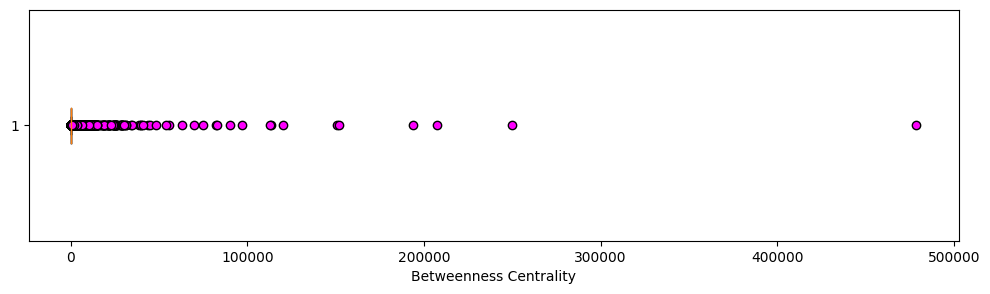

In [34]:
plot_betweenness_centrality_descriptive_stats(large_graph_bc, "magenta")

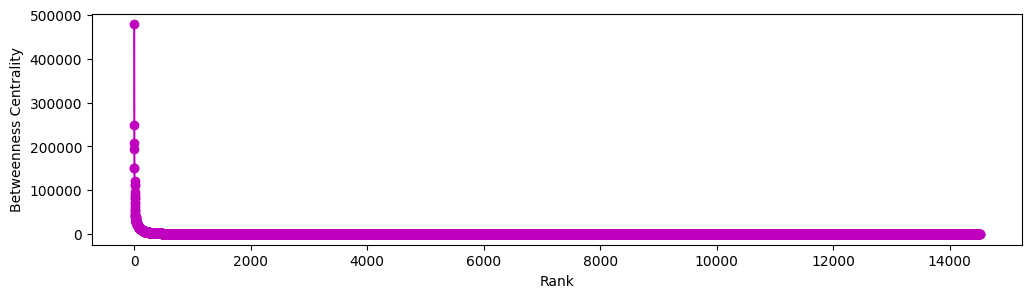

In [35]:
plot_betweenness_centrality_ranking(large_graph_bc, "mo-")

In [36]:
lg_critical_groups, _ = get_betweenness_centrality_critical_nodes_for_count(
    large_graph_bc, 10
)
print(f"\n{lg_critical_groups}")

10-critical-groups node count: 10


{478745.5761920822: ['4000118'], 249844.0524604049: ['4002097'], 207362.93915076088: ['4001330'], 193454.48571428863: ['4000777'], 151635.79488464733: ['4009302'], 150508.62821798064: ['4001770'], 120212.12821798072: ['4008239'], 113250.38765123766: ['4000092'], 112585.57266242518: ['4008428'], 96838.22520137655: ['4001327']}


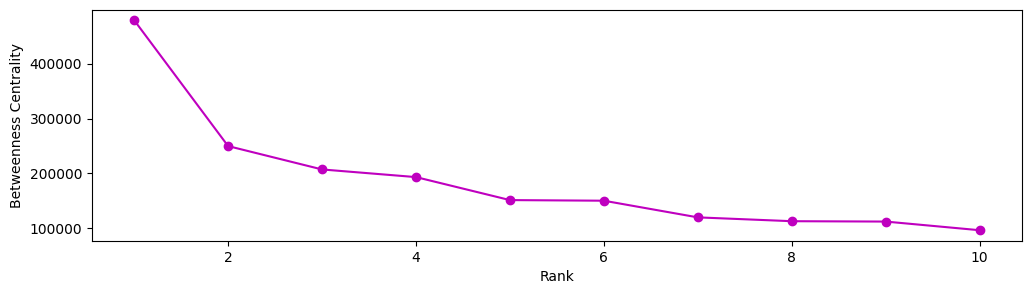

In [37]:
plot_betweenness_centrality_ranking(
    large_graph_bc,
    "mo-",
    stop_at=list(lg_critical_groups.keys())[-1],
)